Imports


In [16]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

Data Load

In [17]:
df = pd.read_csv("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


<function matplotlib.pyplot.show(close=None, block=None)>

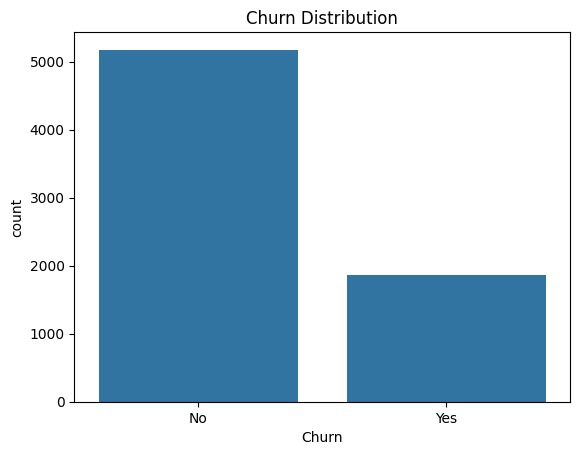

In [18]:
df. info()
df.describe(include=[np.number])
df["Churn"].value_counts()

sns.countplot(x="Churn", data=df)
plt.title("Churn Distribution")
plt.show

Clean & encode

In [19]:
df.drop("customerID", axis=1, inplace=True)

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

for col in df.select_dtypes(include=["object"]).columns:
    if df[col].nunique() == 2:
        df[col] = LabelEncoder().fit_transform(df[col])
    else:
        df[col] = df[col].astype("category").cat.codes

df.head()

C:\Users\Vaibhavi Rane\AppData\Local\Temp\ipykernel_9700\2625435248.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


Split & scale

In [20]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

def evaluate_model(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    fpr=tpr=roc_auc=None
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        print(f"ROC-AUC: {roc_auc:.4f}")
    return fpr, tpr, roc_auc


Train & compare three models


=== Logistic Regression ===
Accuracy: 0.8155
Confusion Matrix:
 [[933 103]
 [157 216]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.68      0.58      0.62       373

    accuracy                           0.82      1409
   macro avg       0.77      0.74      0.75      1409
weighted avg       0.81      0.82      0.81      1409

ROC-AUC: 0.8614

=== Random Forest ===
Accuracy: 0.7984
Confusion Matrix:
 [[946  90]
 [194 179]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1036
           1       0.67      0.48      0.56       373

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.71      1409
weighted avg       0.79      0.80      0.79      1409

ROC-AUC: 0.8402

=== XGBoost ===
Accuracy: 0.8034
Confusion Matrix:
 [[932 104]
 [173 200]]
Classification Repor

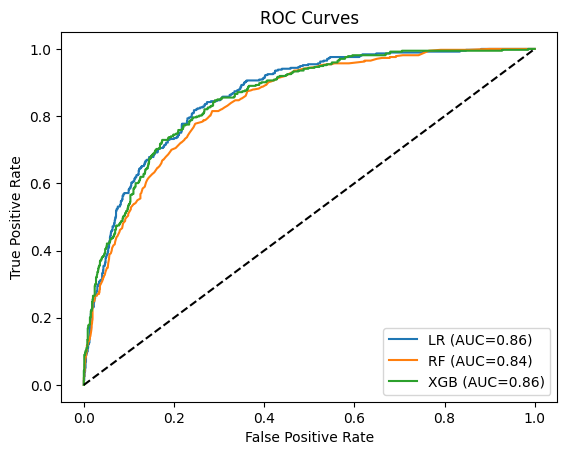

In [21]:
lr_fpr, lr_tpr, lr_auc = evaluate_model(LogisticRegression(max_iter=1000),
                                        X_train_s, X_test_s, y_train, y_test, "Logistic Regression")

rf_fpr, rf_tpr, rf_auc = evaluate_model(RandomForestClassifier(n_estimators=200, random_state=42),
                                        X_train_s, X_test_s, y_train, y_test, "Random Forest")

xgb = XGBClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=5,
    subsample=0.9, colsample_bytree=0.9, random_state=42, eval_metric="logloss"
)
xgb_fpr, xgb_tpr, xgb_auc = evaluate_model(xgb, X_train_s, X_test_s, y_train, y_test, "XGBoost")

# Plot ROC curves
plt.figure()
if lr_fpr is not None:  plt.plot(lr_fpr,  lr_tpr,  label=f"LR (AUC={lr_auc:.2f})")
if rf_fpr is not None:  plt.plot(rf_fpr,  rf_tpr,  label=f"RF (AUC={rf_auc:.2f})")
if xgb_fpr is not None: plt.plot(xgb_fpr, xgb_tpr, label=f"XGB (AUC={xgb_auc:.2f})")
plt.plot([0,1],[0,1], "k--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves"); plt.legend(); plt.show()
